### NBA Fantasy

Opravili bomo analizo NBA sezone 2016/2017 z vidika NBA Fantasy točkovanja ter primerjal "natančnost" najpopularnejše metode točkovanja igralcev glede na dejansko uspešnost ekip v rednem delu sezone.


Najprej naložimo vse .csv datoteke s podatki in si oglejmo, kateri podatki so nam na voljo za vsakega igralca:

In [ ]:
import pandas as pd
import matplotlib as mplot

%matplotlib inline
pd.options.display.max_rows = 20
pd.set_option('precision', 2)
statistike = pd.read_csv('stats.csv', index_col = 'Index')
ekipe = pd.read_csv('team_stats.csv')
dvojni_dvojcki = pd.read_csv('dd.csv')
boljse_statistike = pd.merge(statistike, dvojni_dvojcki, how = 'outer')
boljse_statistike


Tabelo igralcev sedaj združimo s statistiko zmag in porazov vsake ekipe:

In [ ]:
igralci = pd.merge(boljse_statistike, ekipe, left_on = 'Team', right_on = 'Team', how = 'left')
igralci

Takoj lahko opazimo, da imajo nekateri igralci prazno statistiko zmag in porazov. Po natančnejšem pregledu podatkov lahko ugotovimo, kaj imajo vsi ti igralci skupnega: igrajo v ekipi "TOT".

In [ ]:
igralci[igralci.Team == 'TOT']

"TOT" seveda ni ekipa, predstavlja skupno statistiko celotne sezone igralcev, ki so bili med letom zamenjani v drugo ekipo. Takih igralcev je skupno 53, kar ni ravno zanemarljivo (glede na skupno št. igralcev: 485), a jih v analizi uspeha ekip ne bomo mogli upoštevati, saj nimamo podatka o tem, v katerih ekipah so igrali ter koliko tekem v vsaki. Pri analizah individualnih statistik pa jih bomo seveda upoštevali.

Kot lahko razberemo iz zgornje razpredelnice, je statističnih kategorij, ki so v košarki relevantne, precej. Pri analizi dejanskega učinka igralcev na igrišču se zato ponavadi uporablja indeks PER, ki pa sam po sebi ni dovolj natančen, saj ga je treba vedno interpretirati v povezavi z odigranim časom posameznega igralca, sama formula pa je preveč zapletena in zato neprivlačna za manj strokovno podkovane košarkarske navdušence. Pri NBA Fantasy igrah na različnih spletnih straneh, pri katerih se med seboj pomerja milijone uporabnikov, je zato najpopularnejši način vrednotenja igralcev po vsaki tekmi spodnja formula, ki upošteva mosnovne statistične kategorije in jih različno obteži glede na dejansko "korist" posamezne statistike na igrišču, tako je na primer dosežena točka enako vredna kot zgrešen met, blokada pa pol točke več kot obrambni skok. Dodatne bonuse predstavljajo t. i. "dvojni" oz. "trojni dvojčki" ("Double double" in "Triple double" v angleščini - kadar igralec v različnih "pozitivnih" statistikah doseže dvomestno številko) ter zmaga ali poraz ekipe na posamezni tekmi.

Definirajmo torej formulo in izračunajmo povprečno ter skupno vrednost za vsakega igralca:

In [ ]:
def fantasy_total(row):
    bonus = 5 * (row.DD + row.TD) + row.GS
    if not pd.isnull(row.Wins):
        team_bonus = 3 * (row.Wins - row.Losses) * row.GP / 82
    else:
        team_bonus = 0
    return row.GP * (row.PTS + row.DREB + (row.FG - row.FGA) + (row.FT - row.FTA) + 1.25 * row.OREB + 1.5 * (row.AST + row.STL + row.BLK - row.TO)) + bonus + team_bonus

In [ ]:
igralci['FANTASY_TOT'] = igralci.apply (lambda row: fantasy_total(row), axis=1)
igralci['FANTASY_AVG'] = igralci.apply (lambda row: fantasy_total(row)/row.GP, axis=1)
igralci

Za malo bolj smiseln pogled uredimo tabelo po povprečni vrednosti fantasy točkovanja:

In [ ]:
igralci = igralci.sort_values(by = "FANTASY_AVG", ascending = False)
igralci

Poleg kar velikih razlik v povprečjih v samem vrhu, takoj opazimo, da ima nekaj igralcev negativno povprečje. Poudariti je treba, da to NI NAPAKA, saj ocenjevalna formula predvideva tudi negativne statistične kategorije: Tako ni sploh redko, da igralec ob slabi tekmi in, denimo, celo porazu svoje ekipe, doseže krepko negativno fantasy točkovanje.

In [ ]:
igralci.plot.scatter('FANTASY_AVG', 'FANTASY_TOT')

Z zgornjim grafom lahko na hitro (vendar natančno) preverimo, če je kakšno izrazito odstopanje od linearne odvisnosti skupne in povprečne vrednosti fantasy točkovanja, ki bi bila odvisna od npr. zelo majhnega števila odigranih tekem kakšnega igralca zaradi poškodbe. Nekaj takih primerov lahko opazimo, iz česar lahko sklepamo, da je nekaj igralcev (tudi boljših) moralo izpustiti večje število tekem, a je vzorec odigranih tekem še vedno dovolj velik, da jih lahko upoštevamo pri analizi.

V košarki so ponavadi zanimive (in hkrati nehvaležne) primerjave statistik igralcev, ki igrajo na različnih pozicijah:

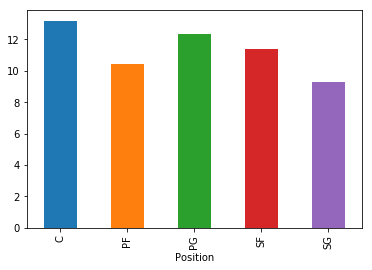

In [27]:
igralci.groupby('Position').mean().FANTASY_AVG.plot.bar()

Pred samo analizo dobljenega rezultata se spomnimo še same definicije pozicij:
    
C  - center

PF - krilni center

SF - krilo

SG - branilec

PG - organizator igre

Iz samega grafa lahko sicer opazimo nekaj razlik med pozicijami, ki pa niso pretirane. V bistvu bi lahko iz grafa sklepali, da tako točkovanje rahlo privilegira centre in organizatorje igre, saj imajo ti več možnosti, da dosežejo "dvojni dvojček"; prvi s skoki, drugi pa z asistencami. Vsekakor pa kar dobro uteži različne statistike. 

Po opravljeni osnovni analizi uspešnosti igralcev nam ostane še zanimivejši del: še tako dobra statistika igralca je popolnoma nekoristna, če ekipa na koncu zabeleži poraz. Skušali bomo torej preveriti, če je fantasy točkovanje merodajno tudi pri uspešnosti posameznih ekip.

In [ ]:
fantasy_povprecje = igralci.groupby('Team').mean().FANTASY_TOT
fantasy_lestvica = fantasy_povprecje.sort_values(ascending = False)
fantasy_lestvica = pd.Series.to_frame(fantasy_lestvica)
fantasy_lestvica

In [ ]:
lestvica = ekipe.sort_values('Losses')
lestvica['Position'] = ekipe.index + 1
lestvica = lestvica[['Position', 'Team', 'Wins']]
lestvica['Index'] = lestvica['Position']
lestvica.set_index('Index', inplace=True)
lestvica

In [ ]:
skupna_lestvica = pd.merge(lestvica, fantasy_lestvica, left_on = 'Team', right_on = 'Team')
skupna_lestvica


In [ ]:
pregled = igralci[['Name', 'Position', 'Team', 'MIN', 'FANTASY_AVG']]
pregled

In [ ]:
graf1 = lestvica.plot.scatter('Position', 'Wins')
graf1

In [ ]:
graf2 = skupna_lestvica.plot.scatter( 'Wins', 'FANTASY_TOT')